In [1]:
!pip install imblearn

import os

import pandas as pd
import numpy as np

# Matplotlib for visualization
from matplotlib import pyplot as plt

# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns

# scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

# Function for creating model pipelines - sklearn
from sklearn.pipeline import make_pipeline

# Function for creating model pipelines - imblearn
from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-sampling using SMOTE
from imblearn.over_sampling import SMOTE


In [2]:
abt = pd.read_csv("../Resources/Analytical_Base_Table.csv")
abt.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,30.5,33.6,0.627000,50.0,1
1,1.0,85.0,66.0,29.0,30.5,26.6,0.351000,31.0,0
2,8.0,183.0,64.0,23.0,30.5,23.3,0.672000,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167000,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,0.471876,33.0,1


## Models Training

## Let's start by splitting our dataframe into separate objects:

y for the target varibale

X for the input features

In [3]:
X = abt.drop(["class"], axis=1)

y = abt["class"]

# display shapes of X and y
print(X.shape, y.shape)

(768, 8) (768,)


In [4]:
# List numerical features
num_colums = X.select_dtypes(include='number').columns.tolist()
num_colums

['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']

In [5]:
# List categorical features
cat_columns = X.select_dtypes(include='object').columns.tolist()
cat_columns

[]

In [6]:
# distribution of diabetics
col1 = y.value_counts()
col2 = y.value_counts(normalize=True)*100
pd.DataFrame(data={'Target':[0,1],'Diabetic':col1,'Diabetic %':col2.round(2)})

,Target,Diabetic,Diabetic %
0,0,500,65.1
1,1,268,34.9


About 35% of people are Diabetic and 65% of the people are non-Diabetic. 

## Create a Train Test Split

We will continue with splitting our data into separate training and test sets.

30% of observations will be set aside for the test set

the rest, 70%, will be used as the training set

In [7]:
random_state = 10

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=random_state)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

537 231 537 231


In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537 entries, 491 to 265
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    537 non-null    float64
 1   plas    537 non-null    float64
 2   pres    537 non-null    float64
 3   skin    537 non-null    float64
 4   test    537 non-null    float64
 5   mass    537 non-null    float64
 6   pedi    537 non-null    float64
 7   age     537 non-null    float64
dtypes: float64(8)
memory usage: 37.8 KB


## Pre-processing Pipeline
 
 ##Scale numerical data and encode categorical data
Construct a pre-processing pipeline from the given transformers: MinMaxScaler and OneHotEncoder Create lists of indexes from the list of column namesNeed to be numeric not string to specify columns name in column transformer

In [9]:
num_features = [] 

for i in num_colums:
    location = X.columns.get_loc(i)
    num_features.append(location)
print(num_features)  

[0, 1, 2, 3, 4, 5, 6, 7]


In [10]:
cat_features = []

for i in cat_columns:
    location = X.columns.get_loc(i)
    cat_features.append(location)
print(cat_features) 

[]


In [11]:
# Define column transformer
# Need to be numeric not string to specify columns name 
preprocess = make_column_transformer(
    (MinMaxScaler(), num_features),
    (OneHotEncoder(sparse=False), cat_features)
)
preprocess

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 [0, 1, 2, 3, 4, 5, 6, 7]),
                                ('onehotencoder', OneHotEncoder(sparse=False),
                                 [])])

In [12]:
# Import classifier
from sklearn.linear_model import LogisticRegression 

# Define model with pipeline
model = imbl_pipe(preprocess,
                  SMOTE(sampling_strategy='auto', random_state=random_state),
                  LogisticRegression(random_state=random_state))

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [0, 1, 2, 3, 4, 5, 6, 7]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  [])])),
                ('smote', SMOTE(random_state=10)),
                ('logisticregression', LogisticRegression(random_state=10))])

In [13]:
 # Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
lr_param_grid = {
    'logisticregression__C' : [0.01, 0.05, 0.1, 0.5, 1, 5],
    'logisticregression__solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
}

lr_grid = GridSearchCV(model, lr_param_grid, verbose=3, cv= 5, scoring='accuracy')

In [14]:
lr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END logisticregression__C=0.01, logisticregression__solver=liblinear;, score=0.463 total time=   0.0s
[CV 2/5] END logisticregression__C=0.01, logisticregression__solver=liblinear;, score=0.620 total time=   0.0s
[CV 3/5] END logisticregression__C=0.01, logisticregression__solver=liblinear;, score=0.495 total time=   0.0s
[CV 4/5] END logisticregression__C=0.01, logisticregression__solver=liblinear;, score=0.523 total time=   0.0s
[CV 5/5] END logisticregression__C=0.01, logisticregression__solver=liblinear;, score=0.486 total time=   0.0s
[CV 1/5] END logisticregression__C=0.01, logisticregression__solver=newton-cg;, score=0.759 total time=   0.0s
[CV 2/5] END logisticregression__C=0.01, logisticregression__solver=newton-cg;, score=0.750 total time=   0.0s
[CV 3/5] END logisticregression__C=0.01, logisticregression__solver=newton-cg;, score=0.664 total time=   0.0s
[CV 4/5] END logisticregression__C=0.01, logisticr

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6,
                                                                          7]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse=False),
                                                                         [])])),
                                       ('smote', SMOTE(random_state=10)),
                                       ('logisticregression',
                                        LogisticRegression(random_state=10))]),
             param_grid={'logisticregression__C': [0.01, 0.05, 0.1, 0.5, 1, 5],
                         'logisticregression__solver': ['liblinear',
                                                        'newton-cg', 'lbfgs',
                                                        'sag', 'saga']},
             scoring='accuracy', verbose=3)

In [15]:
print(lr_grid.best_params_)

{'logisticregression__C': 5, 'logisticregression__solver': 'liblinear'}


In [16]:
print(lr_grid.best_score_)

0.7523191415714778


In [17]:
print(f"Training Data Score: {lr_grid.score(X_train, y_train)}")
print(f"Testing Data Score: {lr_grid.score(X_test, y_test)}")

Training Data Score: 0.7579143389199255
Testing Data Score: 0.7359307359307359


In [18]:
predictions = lr_grid.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   [1 0 1 0 0 0 0 0 0 1]
First 10 Actual labels: [0, 0, 0, 1, 0, 0, 0, 1, 0, 0]


In [19]:
X_test.iloc[0]

preg      4.000
plas    154.000
pres     72.000
skin     29.000
test    126.000
mass     31.300
pedi      0.338
age      37.000
Name: 568, dtype: float64

In [20]:
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)

,Prediction,Actual
0,1,0
1,0,0
2,1,0
3,0,1
4,0,0
...,...,...
226,1,0
227,1,1
228,0,0
229,0,0


In [21]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[109  35]
 [ 26  61]]


In [22]:
cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
print(cm)

[[0.76 0.24]
 [0.3  0.7 ]]


In [23]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78       144
           1       0.64      0.70      0.67        87

    accuracy                           0.74       231
   macro avg       0.72      0.73      0.72       231
weighted avg       0.74      0.74      0.74       231



In [24]:
pred = lr_grid.predict(X_test[:1])

In [25]:
print(f"Predicted classes: {pred}")
print(f"Actual Labels: {list(y_test[:1])}")

Predicted classes: [1]
Actual Labels: [0]


In [26]:
import joblib

filename = '../models/challa_logistic_regression.sav'
joblib.dump(lr_grid, filename)

['../models/challa_logistic_regression.sav']

In [27]:
lr_model = joblib.load(filename)
print(lr_model.score(X_test, y_test))

0.7359307359307359


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [29]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [30]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [31]:
LR_perf_train = model_performance_classification_sklearn(lr_grid, X_train, y_train)
LR_perf_train

,Accuracy,Recall,Precision,F1
0,0.757914,0.729282,0.619718,0.670051


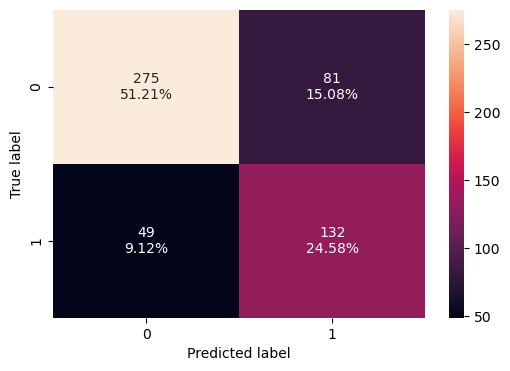

In [32]:
confusion_matrix_sklearn(lr_grid, X_train, y_train)

In [33]:
LR_perf_test = model_performance_classification_sklearn(lr_grid, X_test, y_test)
LR_perf_test

,Accuracy,Recall,Precision,F1
0,0.735931,0.701149,0.635417,0.666667


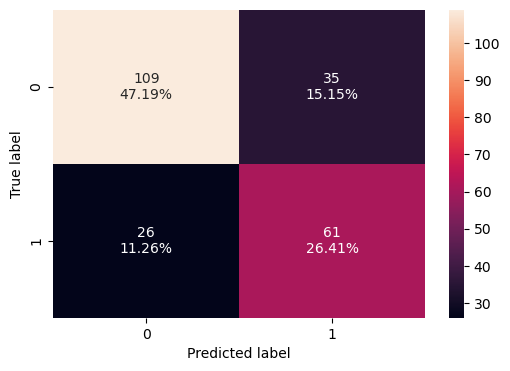

In [34]:
confusion_matrix_sklearn(lr_grid, X_test, y_test)

In [35]:
df1 = pd.DataFrame(model_performance_classification_sklearn(lr_grid, X_test, y_test).T).reset_index().rename(columns={'index':'Metrics_names',0:'Testing_Metrics'})
df1

,Metrics_names,Testing_Metrics
0,Accuracy,0.735931
1,Recall,0.701149
2,Precision,0.635417
3,F1,0.666667


In [36]:
df2 = pd.DataFrame(model_performance_classification_sklearn(lr_grid, X_train, y_train).T).reset_index().rename(columns={'index':'Metrics_names',0:'Training_Metrics'})
df2

,Metrics_names,Training_Metrics
0,Accuracy,0.757914
1,Recall,0.729282
2,Precision,0.619718
3,F1,0.670051


In [37]:
Output_df = pd.merge(df2, df1, on='Metrics_names')
display(Output_df)

,Metrics_names,Training_Metrics,Testing_Metrics
0,Accuracy,0.757914,0.735931
1,Recall,0.729282,0.701149
2,Precision,0.619718,0.635417
3,F1,0.670051,0.666667


In [38]:
print("Diabetes diagnosis probability is {}".format(lr_grid.predict_proba(X_train)[:, 1][0]))

Diabetes diagnosis probability is 0.236569842165346


In [39]:
X_train

,preg,plas,pres,skin,test,mass,pedi,age
491,2.0,89.0,90.000000,30.0,30.5,33.500000,0.292,42.0
69,4.0,146.0,85.000000,27.0,100.0,28.900000,0.189,27.0
667,10.0,111.0,70.000000,27.0,30.5,27.500000,0.141,40.0
566,1.0,99.0,72.000000,30.0,18.0,38.600000,0.412,21.0
97,1.0,71.0,48.000000,18.0,76.0,20.400000,0.323,22.0
...,...,...,...,...,...,...,...,...
369,1.0,133.0,102.000000,28.0,140.0,32.800000,0.234,45.0
320,4.0,129.0,60.000000,12.0,231.0,27.500000,0.527,31.0
527,3.0,116.0,74.000000,15.0,105.0,26.300000,0.107,24.0
125,1.0,88.0,72.386719,42.0,99.0,32.450911,0.496,26.0


In [40]:
X_train.columns

Index(['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age'], dtype='object')

In [41]:
x_test = pd.DataFrame([X_train.iloc[10]])
x_test

,preg,plas,pres,skin,test,mass,pedi,age
766,1.0,126.0,60.0,23.0,30.5,30.1,0.349,47.0


In [42]:
num_colums, cat_columns

(['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age'], [])

In [43]:
output = lr_grid.predict_proba(x_test)[0,1]

In [44]:
if output > 0.5:
    print("The customer is diabetic and diabetes prediction probability is {}".format(output))
else:
    print("The customer is non-diabetic and diabetes detection probability is {}".format(output))

The customer is non-diabetic and diabetes detection probability is 0.48608710109825415


In [52]:
customer = X_train.iloc[10].to_dict()
customer

{'preg': 1.0,
 'plas': 126.0,
 'pres': 60.0,
 'skin': 23.0,
 'test': 30.5,
 'mass': 30.1,
 'pedi': 0.349,
 'age': 47.0}

In [46]:
# customer = X_train.iloc[100].to_dict()
# import requests
# url = 'https://tel-churn-pred-nx4awh3s5q-nw.a.run.app/predict'
# response = requests.post(url, json=customer)
# result = response.json()
# print(result)

In [47]:
# http://127.0.0.1:9696 : Flask, http://172.17.0.2:8501 : Docker

SyntaxError: invalid syntax (1801024190.py, line 1)

In [57]:
# This is the test code for testing flask app
customer = X_train.iloc[100].to_dict()
import requests
url = 'http://192.168.1.219:8888/predict'
response = requests.post(url, json=customer)
result = response.json()
print(result)

{'Diabetes_Prediction': 1.0, 'Diabetic_Prediction_Probability': 0.542663703936888}


In [ ]:
# This is the test code for testing flask app
customer = X_train.iloc[100].to_dict()
import requests
url = 'http://172.17.0.2:8502/predict'
response = requests.post(url, json=customer)
result = response.json()
print(result)

ConnectTimeout: HTTPConnectionPool(host='172.17.0.2', port=8502): Max retries exceeded with url: /predict (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x0000020DC9301D50>, 'Connection to 172.17.0.2 timed out. (connect timeout=None)'))